In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime
from tqdm import tqdm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Configuration

WINDOW_SIZE = 30
HORIZON = 7
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
!nvidia-smi

Sun May  4 21:26:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset Preparation for Protest Labels

In [ ]:
PROTEST_KEYWORDS = ["protest", "demonstration", "strike", "rally", "boycott", "unrest", "riot"]

def flag_protest(text):
  text_l = str(text).lower()
  return any(k in text_l for k in PROTEST_KEYWORDS)


In [ ]:
def build_dataset(csv_path):
  df = pd.read_csv(csv_path)
  df["timestamp"] = pd.to_datetime(df["DATE"], format="%Y%m%d%H%M%S", errors="coerce")
  df = df.dropna(subset=["timestamp"])
  df["date"] = pd.to_datetime(df["timestamp"].dt.date)
  df["country"] = df["Country1"].fillna(df["Country2"])
  df["is_protest"] = df["CONTENT"].map(flag_protest)

  df_p = df[df["is_protest"]]
  daily = df_p.groupby(["country", "date"]).size().rename("count").reset_index()

  all_dates = pd.date_range(daily["date"].min(), daily["date"].max(), freq="D")
  countries = daily["country"].unique()
  full_idx = pd.MultiIndex.from_product([countries, all_dates], names=["country", "date"])
  daily_full = daily.set_index(["country", "date"]).reindex(full_idx, fill_value=0).reset_index()

  daily_full = daily_full.sort_values(["country", "date"])
  daily_full["future_sum"] = (
      daily_full.groupby("country")["count"]
      .transform(lambda s: s.rolling(window=HORIZON, min_periods=1).sum().shift(-HORIZON + 1))
  )
  daily_full["label"] = (daily_full["future_sum"] > 0).astype(int)
  daily_full.drop(columns=["future_sum"], inplace=True)

  # Save processed dataset
  daily_full.to_csv("/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset.csv", index=False)

  return daily_full


## PyTorch Dataset

In [7]:
class ProtestSequenceDataset(Dataset):
  def __init__(self, df, window_size=30, horizon=7):
    self.samples = []
    for country in df["country"].unique():

      c_df = df[df["country"] == country].sort_values("date").reset_index(drop=True)
      counts = c_df["count"].values
      labels = c_df["label"].values

      for i in range(len(c_df) - window_size - horizon):
        x = counts[i : i + window_size]
        y = labels[i + window_size + horizon - 1]
        self.samples.append((torch.tensor(x, dtype=torch.float32),
                              torch.tensor(y, dtype=torch.float32)))

  def __len__(self):
      return len(self.samples)

  def __getitem__(self, idx):
      return self.samples[idx]

## LSTM Model

In [ ]:
class ProtestLSTM(nn.Module):
  def __init__(self, input_dim=1, hidden_dim=64):
    super().__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
    self.fc = nn.Sequential(
        nn.Linear(hidden_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )

  def forward(self, x):
    x = x.unsqueeze(-1)  # (B, T, 1)
    _, (hn, _) = self.lstm(x)
    return self.fc(hn[-1]).squeeze(1)  # (B,)

## Transformer Model

In [ ]:
class ProtestTransformer(nn.Module):
  def __init__(self, input_dim=1, d_model=64, n_heads=4, n_layers=2):
    super().__init__()
    self.input_proj = nn.Linear(input_dim, d_model)
    encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layer, n_layers)
    self.pool = nn.AdaptiveAvgPool1d(1)
    self.classifier = nn.Sequential(
        nn.Linear(d_model, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )

  def forward(self, x):
    x = x.unsqueeze(-1)  # (B, T, 1)
    x = self.input_proj(x)  # (B, T, d_model)
    x = x.permute(1, 0, 2)  # (T, B, d_model)
    x = self.encoder(x)     # (T, B, d_model)
    x = x.permute(1, 2, 0)  # (B, d_model, T)
    x = self.pool(x).squeeze(-1)  # (B, d_model)
    return self.classifier(x).squeeze(1)  # (B,)

## Training

In [ ]:
def train_epoch(model, dataloader, optimizer, loss_fn):
  model.train()
  total_loss = 0
  y_true = []
  y_pred = []
  for x_batch, y_batch in dataloader:
    x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
    preds = model(x_batch)
    loss = loss_fn(preds, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    y_true.extend(y_batch.cpu().numpy())
    y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())
  acc = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  return total_loss / len(dataloader), acc, f1, y_true, y_pred


In [ ]:
# Load and process data
csv_path = "/content/drive/MyDrive/WORLDREP_Event_Predicting/data/worldrep_dataset_v2.csv"
df = build_dataset(csv_path)

In [ ]:
df.head()

,country,date,count,label
0,ABW,2015-02-18,0,0
1,ABW,2015-02-19,0,0
2,ABW,2015-02-20,0,0
3,ABW,2015-02-21,0,0
4,ABW,2015-02-22,0,0


In [ ]:
train_df = df[df["date"] < pd.to_datetime("2022-01-01")]
val_df = df[(df["date"] >= pd.to_datetime("2022-01-01")) & (df["date"] < pd.to_datetime("2022-07-01"))]
test_df = df[df["date"] >= pd.to_datetime("2022-07-01")]

print("Label Distribution:")
print("Train:", train_df["label"].value_counts().to_dict())
print("Val:", val_df["label"].value_counts().to_dict())
print("Test:", test_df["label"].value_counts().to_dict())

train_dataset = ProtestSequenceDataset(train_df, window_size=WINDOW_SIZE, horizon=HORIZON)
val_dataset = ProtestSequenceDataset(val_df, window_size=WINDOW_SIZE, horizon=HORIZON)
test_dataset = ProtestSequenceDataset(test_df, window_size=WINDOW_SIZE, horizon=HORIZON)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Label Distribution:
Train: {0: 468677, 1: 55704}
Val: {0: 34130, 1: 3699}
Test: {0: 134756, 1: 11126}
Train samples: 516648
Validation samples: 30096
Test samples: 138149


In [ ]:
from torch.nn import BCEWithLogitsLoss

# After splitting data and before training loop
pos_weight = torch.tensor([
    train_df["label"].value_counts()[0] / train_df["label"].value_counts()[1]
]).to(DEVICE)

loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight)


In [ ]:
model = ProtestLSTM().to(DEVICE)  # or ProtestTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(EPOCHS):
  train_loss, train_acc, train_f1, _, _ = train_epoch(model, train_loader, optimizer, loss_fn)
  print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f}")

print("\nFinal Training Metrics:")
print(f"Final Accuracy (Train): {train_acc:.4f}")
print(f"Final F1 Score (Train): {train_f1:.4f}")

print("\nValidation Set Metrics:")
model.eval()
y_true_val, y_pred_val = [], []
with torch.no_grad():
  for x_batch, y_batch in val_loader:
    x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
    preds = model(x_batch)
    y_true_val.extend(y_batch.cpu().numpy())
    y_pred_val.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())
val_acc = accuracy_score(y_true_val, y_pred_val)
val_f1 = f1_score(y_true_val, y_pred_val)
print(f"Final Accuracy (Val): {val_acc:.4f}")
print(f"Final F1 Score (Val): {val_f1:.4f}")

print("\nTest Set Metrics:")
y_true_test, y_pred_test = [], []
with torch.no_grad():
  for x_batch, y_batch in test_loader:
    x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
    preds = model(x_batch)
    y_true_test.extend(y_batch.cpu().numpy())
    y_pred_test.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())
test_acc = accuracy_score(y_true_test, y_pred_test)
test_f1 = f1_score(y_true_test, y_pred_test)
print(f"Final Accuracy (Test): {test_acc:.4f}")
print(f"Final F1 Score (Test): {test_f1:.4f}")


Epoch 1/10, Train Loss: 0.2467, Accuracy: 0.9164, F1 Score: 0.4606
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.9181, F1 Score: 0.4700
Epoch 3/10, Train Loss: 0.2389, Accuracy: 0.9182, F1 Score: 0.4714
Epoch 4/10, Train Loss: 0.2383, Accuracy: 0.9182, F1 Score: 0.4727
Epoch 5/10, Train Loss: 0.2381, Accuracy: 0.9185, F1 Score: 0.4724
Epoch 6/10, Train Loss: 0.2379, Accuracy: 0.9187, F1 Score: 0.4769
Epoch 7/10, Train Loss: 0.2376, Accuracy: 0.9188, F1 Score: 0.4761
Epoch 8/10, Train Loss: 0.2374, Accuracy: 0.9189, F1 Score: 0.4752
Epoch 9/10, Train Loss: 0.2370, Accuracy: 0.9193, F1 Score: 0.4765
Epoch 10/10, Train Loss: 0.2366, Accuracy: 0.9193, F1 Score: 0.4760

Final Training Metrics:
Final Accuracy (Train): 0.9193
Final F1 Score (Train): 0.4760

Validation Set Metrics:
Final Accuracy (Val): 0.9210
Final F1 Score (Val): 0.3866

Test Set Metrics:
Final Accuracy (Test): 0.9396
Final F1 Score (Test): 0.4361


## Transformer Model

In [ ]:
csv_path = "/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset.csv"
df = pd.read_csv(csv_path)

In [ ]:
df.head()

,country,date,count,label
0,ABW,2015-02-18,0,0
1,ABW,2015-02-19,0,0
2,ABW,2015-02-20,0,0
3,ABW,2015-02-21,0,0
4,ABW,2015-02-22,0,0


In [ ]:
model = ProtestTransformer().to(DEVICE)  # or
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(EPOCHS):
  train_loss, train_acc, train_f1, _, _ = train_epoch(model, train_loader, optimizer, loss_fn)
  print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f}")

print("\nFinal Training Metrics:")
print(f"Final Accuracy (Train): {train_acc:.4f}")
print(f"Final F1 Score (Train): {train_f1:.4f}")

print("\nValidation Set Metrics:")
model.eval()
y_true_val, y_pred_val = [], []
with torch.no_grad():
  for x_batch, y_batch in val_loader:
    x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
    preds = model(x_batch)
    y_true_val.extend(y_batch.cpu().numpy())
    y_pred_val.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())
val_acc = accuracy_score(y_true_val, y_pred_val)
val_f1 = f1_score(y_true_val, y_pred_val)
print(f"Final Accuracy (Val): {val_acc:.4f}")
print(f"Final F1 Score (Val): {val_f1:.4f}")

print("\nTest Set Metrics:")
y_true_test, y_pred_test = [], []
with torch.no_grad():
  for x_batch, y_batch in test_loader:
    x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
    preds = model(x_batch)
    y_true_test.extend(y_batch.cpu().numpy())
    y_pred_test.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())
test_acc = accuracy_score(y_true_test, y_pred_test)
test_f1 = f1_score(y_true_test, y_pred_test)
print(f"Final Accuracy (Test): {test_acc:.4f}")
print(f"Final F1 Score (Test): {test_f1:.4f}")


Epoch 1/10, Train Loss: 0.8890, Accuracy: 0.8317, F1 Score: 0.4648
Epoch 2/10, Train Loss: 0.8848, Accuracy: 0.8189, F1 Score: 0.4555
Epoch 3/10, Train Loss: 0.8979, Accuracy: 0.8209, F1 Score: 0.4526
Epoch 4/10, Train Loss: 0.9097, Accuracy: 0.8354, F1 Score: 0.4630
Epoch 5/10, Train Loss: 0.8749, Accuracy: 0.8112, F1 Score: 0.4516
Epoch 6/10, Train Loss: 0.8729, Accuracy: 0.8101, F1 Score: 0.4512
Epoch 7/10, Train Loss: 0.8785, Accuracy: 0.8081, F1 Score: 0.4478
Epoch 8/10, Train Loss: 0.8730, Accuracy: 0.8103, F1 Score: 0.4513
Epoch 9/10, Train Loss: 0.8728, Accuracy: 0.8100, F1 Score: 0.4511
Epoch 10/10, Train Loss: 0.8886, Accuracy: 0.8213, F1 Score: 0.4564

Final Training Metrics:
Final Accuracy (Train): 0.8213
Final F1 Score (Train): 0.4564

Validation Set Metrics:
Final Accuracy (Val): 0.7862
Final F1 Score (Val): 0.3786

Test Set Metrics:
Final Accuracy (Test): 0.8571
Final F1 Score (Test): 0.4324


## Adding NLP-based sentiment features from the CONTENT column

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import pipeline

PROTEST_KEYWORDS = ["protest", "demonstration", "strike", "rally", "boycott", "unrest", "riot"]

def flag_protest(text):
    text_l = str(text).lower()
    return any(k in text_l for k in PROTEST_KEYWORDS)

def build_dataset_with_sentiment(csv_path, horizon=7):
    df = pd.read_csv(csv_path)
    df["timestamp"] = pd.to_datetime(df["DATE"], format="%Y%m%d%H%M%S", errors="coerce")
    df = df.dropna(subset=["timestamp"])
    df["date"] = pd.to_datetime(df["timestamp"].dt.date)
    df["country"] = df["Country1"].fillna(df["Country2"])
    df["is_protest"] = df["CONTENT"].map(flag_protest)

    # Load sentiment model
    sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
    tqdm.pandas()
    df["sentiment_score"] = df["CONTENT"].progress_apply(lambda x: sentiment_analyzer(str(x)[:512])[0]['score'])
    df["sentiment_label"] = df["CONTENT"].progress_apply(lambda x: sentiment_analyzer(str(x)[:512])[0]['label'])
    df["sentiment_value"] = df["sentiment_label"].map({"NEGATIVE": -1, "POSITIVE": 1})

    # Aggregate sentiment per day
    sentiment_daily = df.groupby(["country", "date"]).agg({
        "sentiment_score": "mean",
        "sentiment_value": "mean"
    }).reset_index()

    # Protest-related article counts
    df_p = df[df["is_protest"]]
    daily = df_p.groupby(["country", "date"]).size().rename("count").reset_index()

    # Fill missing dates
    all_dates = pd.date_range(daily["date"].min(), daily["date"].max(), freq="D")
    countries = daily["country"].unique()
    full_idx = pd.MultiIndex.from_product([countries, all_dates], names=["country", "date"])
    daily_full = daily.set_index(["country", "date"]).reindex(full_idx, fill_value=0).reset_index()

    # Merge sentiment scores
    daily_full = daily_full.merge(sentiment_daily, on=["country", "date"], how="left")
    daily_full["sentiment_score"] = daily_full["sentiment_score"].fillna(0)
    daily_full["sentiment_value"] = daily_full["sentiment_value"].fillna(0)

    # Future protest label
    daily_full = daily_full.sort_values(["country", "date"])
    daily_full["future_sum"] = (
        daily_full.groupby("country")["count"]
        .transform(lambda s: s.rolling(window=horizon, min_periods=1).sum().shift(-horizon + 1))
    )
    daily_full["label"] = (daily_full["future_sum"] > 0).astype(int)
    daily_full.drop(columns=["future_sum"], inplace=True)

    # Save if needed
    daily_full.to_csv("/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset_with_sentiment.csv", index=False)
    return daily_full


In [ ]:
import torch
from torch.utils.data import Dataset

class ProtestSequenceDataset(Dataset):
    def __init__(self, df, window_size=30, horizon=7):
        self.samples = []
        for country in df["country"].unique():
            c_df = df[df["country"] == country].sort_values("date").reset_index(drop=True)
            features = c_df[["count", "sentiment_score", "sentiment_value"]].values
            labels = c_df["label"].values

            for i in range(len(c_df) - window_size - horizon):
                x = features[i : i + window_size]
                y = labels[i + window_size + horizon - 1]
                self.samples.append((torch.tensor(x, dtype=torch.float32),
                                     torch.tensor(y, dtype=torch.float32)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

# ---------- LSTM Model ----------
class ProtestLSTM(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # x: (B, T, F)
        return self.fc(hn[-1]).squeeze(1)  # (B,)

# ---------- Transformer Model ----------
class ProtestTransformer(nn.Module):
    def __init__(self, input_dim=3, d_model=64, n_heads=4, n_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):  # x: (B, T, F)
        x = self.input_proj(x)
        x = self.encoder(x)                 # (B, T, d_model)
        x = x.permute(0, 2, 1)             # (B, d_model, T)
        x = self.pool(x).squeeze(-1)       # (B, d_model)
        return self.classifier(x).squeeze(1)

# ---------- Training Function ----------
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    y_true, y_pred = [], []

    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        loss = loss_fn(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return total_loss / len(dataloader), acc, f1

# ---------- Main ----------
def main():
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 10
    WINDOW_SIZE = 30
    HORIZON = 7

    print("Building dataset with sentiment features…")
    df = build_dataset_with_sentiment("/content/drive/MyDrive/WORLDREP_Event_Predicting/data/worldrep_dataset_v2.csv", horizon=HORIZON)

    # Fix date dtype
    df["date"] = pd.to_datetime(df["date"])

    train_df = df[df["date"] < pd.to_datetime("2022-01-01")]
    val_df = df[(df["date"] >= pd.to_datetime("2022-01-01")) & (df["date"] < pd.to_datetime("2022-07-01"))]
    test_df = df[df["date"] >= pd.to_datetime("2022-07-01")]

    train_dataset = ProtestSequenceDataset(train_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    val_dataset = ProtestSequenceDataset(val_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    test_dataset = ProtestSequenceDataset(test_df, window_size=WINDOW_SIZE, horizon=HORIZON)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Class imbalance handling
    pos_weight = torch.tensor([
        train_df["label"].value_counts()[0] / train_df["label"].value_counts()[1]
    ]).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    model = ProtestLSTM(input_dim=3).to(DEVICE)  # or ProtestTransformer(input_dim=3).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Training model…")
    for epoch in range(EPOCHS):
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, loss_fn, DEVICE)
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

    print("\nEvaluating on test set...")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds = model(x_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred)
    print(f"\nTest Accuracy: {test_acc:.4f} | Test F1 Score: {test_f1:.4f}")

if __name__ == "__main__":
    main()


## Increasing Epoch Size

In [ ]:
EPOCHS = 30

In [ ]:
# ---------- Main ----------
def main():
    import matplotlib.pyplot as plt
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 30
    WINDOW_SIZE = 30
    HORIZON = 7
    PATIENCE = 5

    df = pd.read_csv("/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset_with_sentiment.csv")

    # Fix date dtype
    df["date"] = pd.to_datetime(df["date"])

    train_df = df[df["date"] < pd.to_datetime("2022-01-01")]
    val_df = df[(df["date"] >= pd.to_datetime("2022-01-01")) & (df["date"] < pd.to_datetime("2022-07-01"))]
    test_df = df[df["date"] >= pd.to_datetime("2022-07-01")]

    train_dataset = ProtestSequenceDataset(train_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    val_dataset = ProtestSequenceDataset(val_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    test_dataset = ProtestSequenceDataset(test_df, window_size=WINDOW_SIZE, horizon=HORIZON)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Class imbalance handling
    pos_weight = torch.tensor([
        train_df["label"].value_counts()[0] / train_df["label"].value_counts()[1]
    ]).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    model = ProtestLSTM(input_dim=3).to(DEVICE)  # or ProtestTransformer(input_dim=3).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Training model…")
    f1_scores = []
    best_f1 = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, loss_fn, DEVICE)
        f1_scores.append(train_f1)
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

        if train_f1 > best_f1:
            best_f1 = train_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Plot F1 curve
    plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o')
    plt.title("Training F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Load best model
    model.load_state_dict(torch.load("best_model.pt"))

    print("\nEvaluating on test set...")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds = model(x_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred)
    print(f"\nTest Accuracy: {test_acc:.4f} | Test F1 Score: {test_f1:.4f}")


Training model…
Epoch 1/30 - Loss: 0.8141 | Acc: 0.8130 | F1: 0.4659
Epoch 2/30 - Loss: 0.8019 | Acc: 0.8237 | F1: 0.4783
Epoch 3/30 - Loss: 0.8023 | Acc: 0.8252 | F1: 0.4801
Epoch 4/30 - Loss: 0.8005 | Acc: 0.8274 | F1: 0.4824
Epoch 5/30 - Loss: 0.7987 | Acc: 0.8268 | F1: 0.4821
Epoch 6/30 - Loss: 0.7975 | Acc: 0.8269 | F1: 0.4827
Epoch 7/30 - Loss: 0.7962 | Acc: 0.8274 | F1: 0.4836
Epoch 8/30 - Loss: 0.7950 | Acc: 0.8285 | F1: 0.4849
Epoch 9/30 - Loss: 0.7937 | Acc: 0.8282 | F1: 0.4852
Epoch 10/30 - Loss: 0.7926 | Acc: 0.8282 | F1: 0.4853
Epoch 11/30 - Loss: 0.7905 | Acc: 0.8309 | F1: 0.4889
Epoch 12/30 - Loss: 0.7888 | Acc: 0.8303 | F1: 0.4884
Epoch 13/30 - Loss: 0.7867 | Acc: 0.8320 | F1: 0.4907
Epoch 14/30 - Loss: 0.7860 | Acc: 0.8330 | F1: 0.4921
Epoch 15/30 - Loss: 0.7828 | Acc: 0.8344 | F1: 0.4939
Epoch 16/30 - Loss: 0.7804 | Acc: 0.8358 | F1: 0.4961
Epoch 17/30 - Loss: 0.7778 | Acc: 0.8386 | F1: 0.5000
Epoch 18/30 - Loss: 0.7747 | Acc: 0.8404 | F1: 0.5029
Epoch 19/30 - Loss: 0

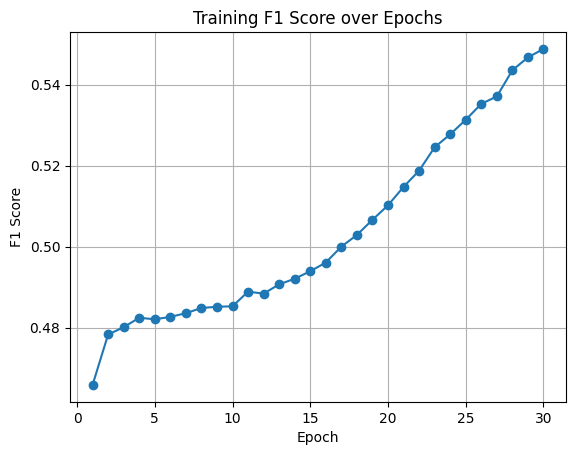


Evaluating on test set...

Test Accuracy: 0.8998 | Test F1 Score: 0.4796


In [ ]:
if __name__ == "__main__":
    main()

Training model…
Epoch 1/20 - Loss: 0.7341 | Acc: 0.8703 | F1: 0.5543
Epoch 2/20 - Loss: 0.7317 | Acc: 0.8721 | F1: 0.5576
Epoch 3/20 - Loss: 0.7280 | Acc: 0.8744 | F1: 0.5621
Epoch 4/20 - Loss: 0.7265 | Acc: 0.8755 | F1: 0.5640
Epoch 5/20 - Loss: 0.7238 | Acc: 0.8762 | F1: 0.5656
Epoch 6/20 - Loss: 0.7205 | Acc: 0.8770 | F1: 0.5678
Epoch 7/20 - Loss: 0.7183 | Acc: 0.8791 | F1: 0.5719
Epoch 8/20 - Loss: 0.7157 | Acc: 0.8800 | F1: 0.5739
Epoch 9/20 - Loss: 0.7148 | Acc: 0.8812 | F1: 0.5759
Epoch 10/20 - Loss: 0.7123 | Acc: 0.8823 | F1: 0.5783
Epoch 11/20 - Loss: 0.7094 | Acc: 0.8834 | F1: 0.5807
Epoch 12/20 - Loss: 0.7086 | Acc: 0.8846 | F1: 0.5835
Epoch 13/20 - Loss: 0.7081 | Acc: 0.8851 | F1: 0.5848
Epoch 14/20 - Loss: 0.7048 | Acc: 0.8856 | F1: 0.5859
Epoch 15/20 - Loss: 0.7040 | Acc: 0.8862 | F1: 0.5869
Epoch 16/20 - Loss: 0.7014 | Acc: 0.8866 | F1: 0.5885
Epoch 17/20 - Loss: 0.6994 | Acc: 0.8881 | F1: 0.5915
Epoch 18/20 - Loss: 0.6988 | Acc: 0.8888 | F1: 0.5930
Epoch 19/20 - Loss: 0

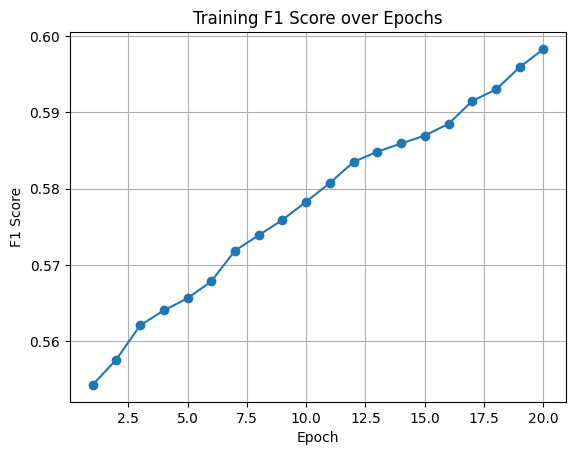


Evaluating on test set...

Test Accuracy: 0.8976 | Test F1 Score: 0.4682


In [ ]:
# ---------- Main ----------
def main():
    import matplotlib.pyplot as plt
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 20
    WINDOW_SIZE = 30
    HORIZON = 7
    PATIENCE = 5

    df = pd.read_csv("/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset_with_sentiment.csv")

    # Fix date dtype
    df["date"] = pd.to_datetime(df["date"])

    train_df = df[df["date"] < pd.to_datetime("2022-01-01")]
    val_df = df[(df["date"] >= pd.to_datetime("2022-01-01")) & (df["date"] < pd.to_datetime("2022-07-01"))]
    test_df = df[df["date"] >= pd.to_datetime("2022-07-01")]

    train_dataset = ProtestSequenceDataset(train_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    val_dataset = ProtestSequenceDataset(val_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    test_dataset = ProtestSequenceDataset(test_df, window_size=WINDOW_SIZE, horizon=HORIZON)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Class imbalance handling
    pos_weight = torch.tensor([
        train_df["label"].value_counts()[0] / train_df["label"].value_counts()[1]
    ]).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    model = ProtestLSTM(input_dim=3).to(DEVICE)
    model.load_state_dict(torch.load("best_model.pt"))  # Load saved weights

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Training model…")
    f1_scores = []
    best_f1 = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, loss_fn, DEVICE)
        f1_scores.append(train_f1)
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

        if train_f1 > best_f1:
            best_f1 = train_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
            torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Plot F1 curve
    plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o')
    plt.title("Training F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Load best model
    model.load_state_dict(torch.load("best_model.pt"))

    print("\nEvaluating on test set...")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds = model(x_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred)
    print(f"\nTest Accuracy: {test_acc:.4f} | Test F1 Score: {test_f1:.4f}")

if __name__ == "__main__":
  main()


Training model…
Epoch 1/20 | Train F1: 0.4682 | Val F1: 0.4420
Epoch 2/20 | Train F1: 0.4783 | Val F1: 0.4458
Epoch 3/20 | Train F1: 0.4771 | Val F1: 0.4441
Epoch 4/20 | Train F1: 0.4799 | Val F1: 0.4413
Epoch 5/20 | Train F1: 0.4824 | Val F1: 0.4542
Epoch 6/20 | Train F1: 0.4822 | Val F1: 0.4333
Epoch 7/20 | Train F1: 0.4817 | Val F1: 0.4305
Epoch 8/20 | Train F1: 0.4818 | Val F1: 0.4389
Epoch 9/20 | Train F1: 0.4832 | Val F1: 0.4590
Epoch 10/20 | Train F1: 0.4848 | Val F1: 0.4491
Epoch 11/20 | Train F1: 0.4833 | Val F1: 0.4328
Epoch 12/20 | Train F1: 0.4850 | Val F1: 0.4471
Epoch 13/20 | Train F1: 0.4878 | Val F1: 0.4534
Epoch 14/20 | Train F1: 0.4930 | Val F1: 0.4371
Early stopping triggered at epoch 14


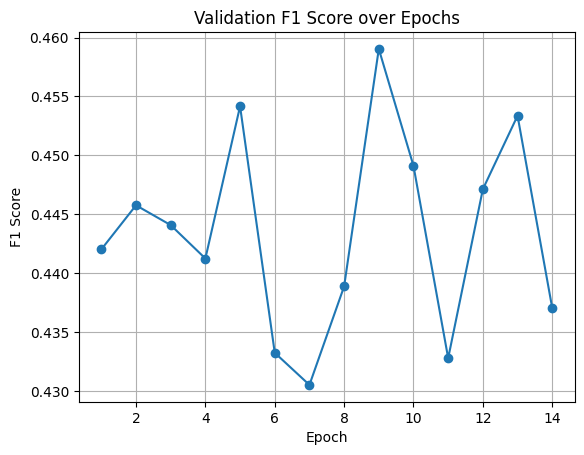


Evaluating on test set...

Test Accuracy: 0.8898 | Test F1 Score: 0.4859


In [ ]:
# ---------- Main ----------
def main():
    import matplotlib.pyplot as plt
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 20
    WINDOW_SIZE = 30
    HORIZON = 7
    PATIENCE = 5

    df = pd.read_csv("/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset_with_sentiment.csv")
    df["date"] = pd.to_datetime(df["date"])

    train_df = df[df["date"] < pd.to_datetime("2022-01-01")]
    val_df = df[(df["date"] >= pd.to_datetime("2022-01-01")) & (df["date"] < pd.to_datetime("2022-07-01"))]
    test_df = df[df["date"] >= pd.to_datetime("2022-07-01")]

    train_dataset = ProtestSequenceDataset(train_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    val_dataset = ProtestSequenceDataset(val_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    test_dataset = ProtestSequenceDataset(test_df, window_size=WINDOW_SIZE, horizon=HORIZON)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    pos_weight = torch.tensor([
        train_df["label"].value_counts()[0] / train_df["label"].value_counts()[1]
    ]).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    model = ProtestLSTM(input_dim=3).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Training model…")
    f1_scores = []
    best_val_f1 = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, loss_fn, DEVICE)

        # ---- Validation evaluation ----
        model.eval()
        val_y_true, val_y_pred = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
                preds = model(x_batch)
                val_y_true.extend(y_batch.cpu().numpy())
                val_y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

        val_acc = accuracy_score(val_y_true, val_y_pred)
        val_f1 = f1_score(val_y_true, val_y_pred)
        f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
            torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Plot validation F1 curve
    plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o')
    plt.title("Validation F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    print("\nEvaluating on test set...")
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds = model(x_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred)
    print(f"\nTest Accuracy: {test_acc:.4f} | Test F1 Score: {test_f1:.4f}")

if __name__ == "__main__":
  main()


## Adding Focal Loss

In [17]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


In [16]:
def train_epoch(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    y_true = []
    y_pred = []

    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        preds = model(x_batch)
        loss = loss_fn(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return total_loss / len(dataloader), acc, f1, y_true, y_pred


## Transformer Model

In [20]:
class ProtestTransformer(nn.Module):
  def __init__(self, input_dim=1, d_model=64, n_heads=4, n_layers=2):
    super().__init__()
    self.input_proj = nn.Linear(input_dim, d_model)
    encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layer, n_layers)
    self.pool = nn.AdaptiveAvgPool1d(1)
    self.classifier = nn.Sequential(
        nn.Linear(d_model, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )

  def forward(self, x):  # x: (B, T, 3)
    x = self.input_proj(x)            # (B, T, d_model)
    x = self.encoder(x)               # (B, T, d_model)
    x = x.permute(0, 2, 1)            # (B, d_model, T)
    x = self.pool(x).squeeze(-1)      # (B, d_model)
    return self.classifier(x).squeeze(1)  # (B,)


In [34]:
class ProtestSequenceDataset(Dataset):
    def __init__(self, df, window_size=30, horizon=7):
        self.samples = []
        for country in df["country"].unique():
            c_df = df[df["country"] == country].sort_values("date").reset_index(drop=True)
            features = c_df[["count", "sentiment_score", "sentiment_value"]].values
            labels = c_df["label"].values

            for i in range(len(c_df) - window_size - horizon):
                x = features[i : i + window_size]
                y = labels[i + window_size + horizon - 1]
                self.samples.append((torch.tensor(x, dtype=torch.float32),
                                     torch.tensor(y, dtype=torch.float32)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


Training model…
Epoch 1/20 | Train F1: 0.4902 | Val F1: 0.4300
Epoch 2/20 | Train F1: 0.4912 | Val F1: 0.3998
Epoch 3/20 | Train F1: 0.4952 | Val F1: 0.4204
Epoch 4/20 | Train F1: 0.4982 | Val F1: 0.4137
Epoch 5/20 | Train F1: 0.4895 | Val F1: 0.4137
Epoch 6/20 | Train F1: 0.4843 | Val F1: 0.4237
Early stopping triggered at epoch 6


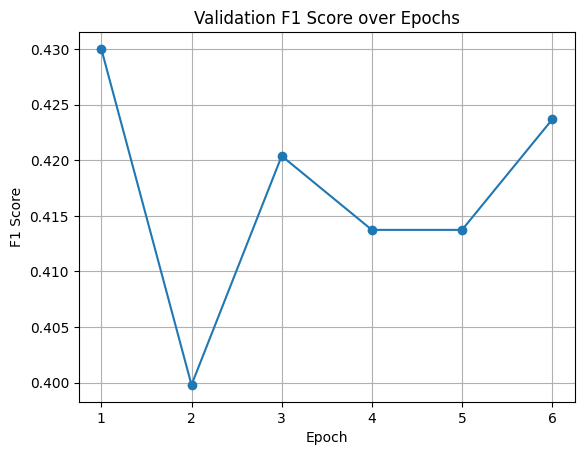


Evaluating on test set...

Test Accuracy: 0.9406 | Test F1 Score: 0.4759


In [21]:
# ---------- Main ----------
def main():
    import matplotlib.pyplot as plt
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 20
    WINDOW_SIZE = 30
    HORIZON = 7
    PATIENCE = 5

    df = pd.read_csv("/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset_with_sentiment.csv")
    df["date"] = pd.to_datetime(df["date"])

    train_df = df[df["date"] < pd.to_datetime("2022-01-01")]
    val_df = df[(df["date"] >= pd.to_datetime("2022-01-01")) & (df["date"] < pd.to_datetime("2022-07-01"))]
    test_df = df[df["date"] >= pd.to_datetime("2022-07-01")]

    train_dataset = ProtestSequenceDataset(train_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    val_dataset = ProtestSequenceDataset(val_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    test_dataset = ProtestSequenceDataset(test_df, window_size=WINDOW_SIZE, horizon=HORIZON)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Use Focal Loss instead of BCE
    loss_fn = FocalLoss(alpha=1.0, gamma=2.0).to(DEVICE)

    model = ProtestTransformer(input_dim=3).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Training model…")
    f1_scores = []
    best_val_f1 = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc, train_f1, _, _ = train_epoch(model, train_loader, optimizer, loss_fn)

        # ---- Validation evaluation ----
        model.eval()
        val_y_true, val_y_pred = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
                preds = model(x_batch)
                val_y_true.extend(y_batch.cpu().numpy())
                val_y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

        val_acc = accuracy_score(val_y_true, val_y_pred)
        val_f1 = f1_score(val_y_true, val_y_pred)
        f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_transformer.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Plot validation F1 curve
    plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o')
    plt.title("Validation F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load("best_model_transformer.pt"))
    model.eval()

    print("\nEvaluating on test set...")
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds = model(x_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred)
    print(f"\nTest Accuracy: {test_acc:.4f} | Test F1 Score: {test_f1:.4f}")


if __name__ == "__main__":
  main()

## LSTM with Focal Loss


In [29]:
class ProtestLSTM(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=2,       # 2 layers to enable dropout
            batch_first=True,
            dropout=0.2         # effective only if num_layers > 1
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):  # x: (B, T, 3)
        _, (hn, _) = self.lstm(x)         # hn: (num_layers, B, hidden_dim)
        return self.fc(hn[-1]).squeeze(1)  # Take output from top layer



Training model…
Epoch 1/20 | Train F1: 0.4894 | Val F1: 0.4354
Epoch 2/20 | Train F1: 0.4930 | Val F1: 0.4217
Epoch 3/20 | Train F1: 0.4952 | Val F1: 0.4251
Epoch 4/20 | Train F1: 0.4973 | Val F1: 0.4166
Epoch 5/20 | Train F1: 0.4977 | Val F1: 0.4120
Epoch 6/20 | Train F1: 0.4993 | Val F1: 0.4020
Early stopping triggered at epoch 6


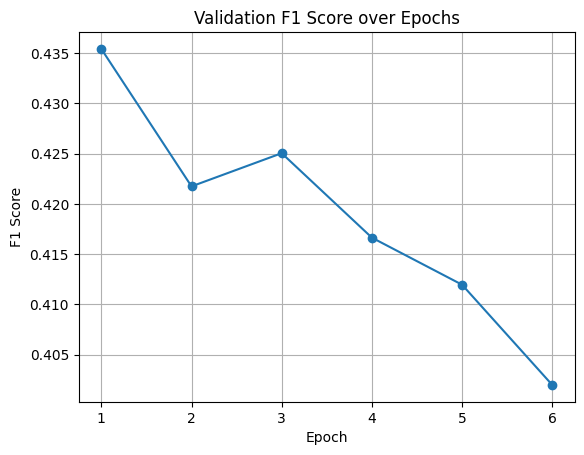


Evaluating on test set...

Test Accuracy: 0.9412 | Test F1 Score: 0.4821


In [23]:
# ---------- Main ----------
def main():
    import matplotlib.pyplot as plt
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 20
    WINDOW_SIZE = 30
    HORIZON = 7
    PATIENCE = 5

    df = pd.read_csv("/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset_with_sentiment.csv")
    df["date"] = pd.to_datetime(df["date"])

    train_df = df[df["date"] < pd.to_datetime("2022-01-01")]
    val_df = df[(df["date"] >= pd.to_datetime("2022-01-01")) & (df["date"] < pd.to_datetime("2022-07-01"))]
    test_df = df[df["date"] >= pd.to_datetime("2022-07-01")]

    train_dataset = ProtestSequenceDataset(train_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    val_dataset = ProtestSequenceDataset(val_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    test_dataset = ProtestSequenceDataset(test_df, window_size=WINDOW_SIZE, horizon=HORIZON)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Use Focal Loss instead of BCE
    loss_fn = FocalLoss(alpha=1.0, gamma=2.0).to(DEVICE)

    model = ProtestLSTM(input_dim=3).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Training model…")
    f1_scores = []
    best_val_f1 = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc, train_f1, _, _ = train_epoch(model, train_loader, optimizer, loss_fn)

        # ---- Validation evaluation ----
        model.eval()
        val_y_true, val_y_pred = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
                preds = model(x_batch)
                val_y_true.extend(y_batch.cpu().numpy())
                val_y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

        val_acc = accuracy_score(val_y_true, val_y_pred)
        val_f1 = f1_score(val_y_true, val_y_pred)
        f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Plot validation F1 curve
    plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o')
    plt.title("Validation F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    print("\nEvaluating on test set...")
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds = model(x_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred)
    print(f"\nTest Accuracy: {test_acc:.4f} | Test F1 Score: {test_f1:.4f}")


if __name__ == "__main__":
  main()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Training model…
Epoch 1/20 | Train F1: 0.4867 | Val F1: 0.3928
Epoch 2/20 | Train F1: 0.4927 | Val F1: 0.4249
Epoch 3/20 | Train F1: 0.4944 | Val F1: 0.4493
Epoch 4/20 | Train F1: 0.4934 | Val F1: 0.4269
Epoch 5/20 | Train F1: 0.4941 | Val F1: 0.3977
Epoch 6/20 | Train F1: 0.4964 | Val F1: 0.4491
Epoch 7/20 | Train F1: 0.5008 | Val F1: 0.4160
Epoch 8/20 | Train F1: 0.5048 | Val F1: 0.4177
Early stopping triggered at epoch 8


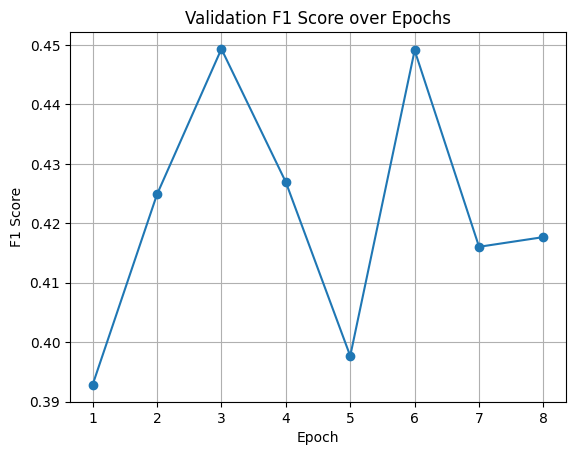


Evaluating on test set...

Test Accuracy: 0.9412 | Test F1 Score: 0.4982


In [25]:
# ---------- Main ---------- changed the lstm architecture
def main():
    import matplotlib.pyplot as plt
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 20
    WINDOW_SIZE = 30
    HORIZON = 7
    PATIENCE = 5

    df = pd.read_csv("/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset_with_sentiment.csv")
    df["date"] = pd.to_datetime(df["date"])

    train_df = df[df["date"] < pd.to_datetime("2022-01-01")]
    val_df = df[(df["date"] >= pd.to_datetime("2022-01-01")) & (df["date"] < pd.to_datetime("2022-07-01"))]
    test_df = df[df["date"] >= pd.to_datetime("2022-07-01")]

    train_dataset = ProtestSequenceDataset(train_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    val_dataset = ProtestSequenceDataset(val_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    test_dataset = ProtestSequenceDataset(test_df, window_size=WINDOW_SIZE, horizon=HORIZON)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Use Focal Loss instead of BCE
    loss_fn = FocalLoss(alpha=1.0, gamma=2.0).to(DEVICE)

    model = ProtestLSTM(input_dim=3).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Training model…")
    f1_scores = []
    best_val_f1 = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc, train_f1, _, _ = train_epoch(model, train_loader, optimizer, loss_fn)

        # ---- Validation evaluation ----
        model.eval()
        val_y_true, val_y_pred = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
                preds = model(x_batch)
                val_y_true.extend(y_batch.cpu().numpy())
                val_y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

        val_acc = accuracy_score(val_y_true, val_y_pred)
        val_f1 = f1_score(val_y_true, val_y_pred)
        f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Plot validation F1 curve
    plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o')
    plt.title("Validation F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    print("\nEvaluating on test set...")
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds = model(x_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred)
    print(f"\nTest Accuracy: {test_acc:.4f} | Test F1 Score: {test_f1:.4f}")


if __name__ == "__main__":
  main()

Training model…
Epoch 1/20 | Train F1: 0.4844 | Val F1: 0.3973
Epoch 2/20 | Train F1: 0.4900 | Val F1: 0.4279
Epoch 3/20 | Train F1: 0.4913 | Val F1: 0.3980
Epoch 4/20 | Train F1: 0.4924 | Val F1: 0.4385
Epoch 5/20 | Train F1: 0.4962 | Val F1: 0.4079
Epoch 6/20 | Train F1: 0.4990 | Val F1: 0.4149
Epoch 7/20 | Train F1: 0.5071 | Val F1: 0.4177
Epoch 8/20 | Train F1: 0.5157 | Val F1: 0.4165
Epoch 9/20 | Train F1: 0.5294 | Val F1: 0.4174
Early stopping triggered at epoch 9


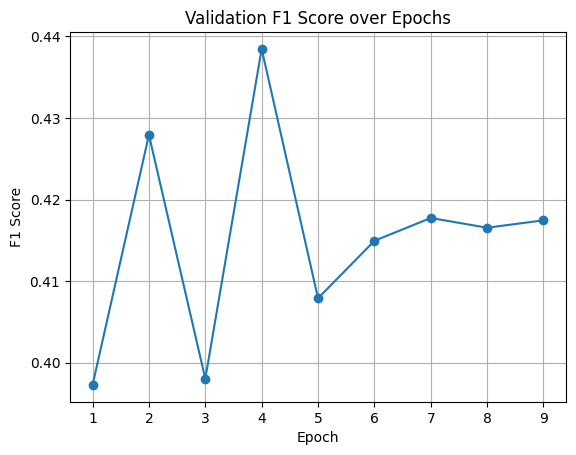


Evaluating on test set...

Test Accuracy: 0.9414 | Test F1 Score: 0.4761


In [30]:
# ---------- Main ---------- changed the lstm architecture
def main():
    import matplotlib.pyplot as plt
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 20
    WINDOW_SIZE = 30
    HORIZON = 7
    PATIENCE = 5

    df = pd.read_csv("/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset_with_sentiment.csv")
    df["date"] = pd.to_datetime(df["date"])

    train_df = df[df["date"] < pd.to_datetime("2022-01-01")]
    val_df = df[(df["date"] >= pd.to_datetime("2022-01-01")) & (df["date"] < pd.to_datetime("2022-07-01"))]
    test_df = df[df["date"] >= pd.to_datetime("2022-07-01")]

    train_dataset = ProtestSequenceDataset(train_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    val_dataset = ProtestSequenceDataset(val_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    test_dataset = ProtestSequenceDataset(test_df, window_size=WINDOW_SIZE, horizon=HORIZON)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Use Focal Loss instead of BCE
    loss_fn = FocalLoss(alpha=1.0, gamma=2.0).to(DEVICE)

    model = ProtestLSTM(input_dim=3).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Training model…")
    f1_scores = []
    best_val_f1 = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc, train_f1, _, _ = train_epoch(model, train_loader, optimizer, loss_fn)

        # ---- Validation evaluation ----
        model.eval()
        val_y_true, val_y_pred = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
                preds = model(x_batch)
                val_y_true.extend(y_batch.cpu().numpy())
                val_y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

        val_acc = accuracy_score(val_y_true, val_y_pred)
        val_f1 = f1_score(val_y_true, val_y_pred)
        f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_new.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Plot validation F1 curve
    plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o')
    plt.title("Validation F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load("best_model_new.pt"))
    model.eval()

    print("\nEvaluating on test set...")
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds = model(x_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred)
    print(f"\nTest Accuracy: {test_acc:.4f} | Test F1 Score: {test_f1:.4f}")


if __name__ == "__main__":
  main()

## Oversampling Protest Labels

In [31]:
from torch.utils.data import Dataset
import torch
import random

class ProtestSequenceDataset(Dataset):
    def __init__(self, df, window_size=30, horizon=7, oversample=True, oversample_factor=2):
        self.samples = []

        for country in df["country"].unique():
            c_df = df[df["country"] == country].sort_values("date").reset_index(drop=True)
            features = c_df[["count", "sentiment_score", "sentiment_value", "Score"]].values
            labels = c_df["label"].values

            for i in range(len(c_df) - window_size - horizon):
                x = features[i : i + window_size]
                y = labels[i + window_size + horizon - 1]
                sample = (torch.tensor(x, dtype=torch.float32),
                          torch.tensor(y, dtype=torch.float32))

                self.samples.append(sample)


                if oversample and y == 1:
                    for _ in range(oversample_factor - 1):
                        self.samples.append(sample)

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


Training model…
Epoch 1/20 | Train F1: 0.5995 | Val F1: 0.5376
Epoch 2/20 | Train F1: 0.6045 | Val F1: 0.5593
Epoch 3/20 | Train F1: 0.6066 | Val F1: 0.5433
Epoch 4/20 | Train F1: 0.6080 | Val F1: 0.5164
Epoch 5/20 | Train F1: 0.6096 | Val F1: 0.5313
Epoch 6/20 | Train F1: 0.6143 | Val F1: 0.5190
Epoch 7/20 | Train F1: 0.6227 | Val F1: 0.5238
Early stopping triggered at epoch 7


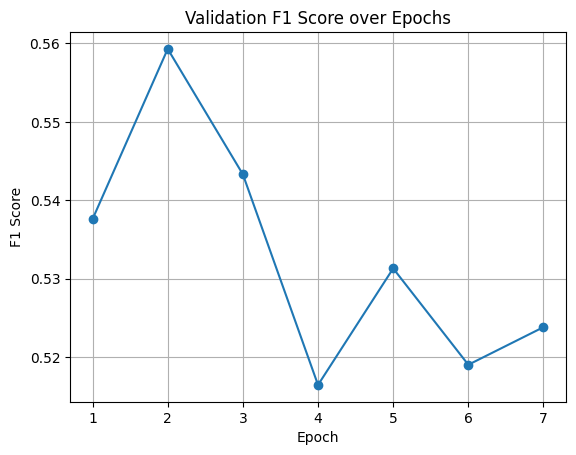


Evaluating on test set...

Test Accuracy: 0.9041 | Test F1 Score: 0.5940


In [32]:
# ---------- Main ---------- changed the lstm architecture
def main():
    import matplotlib.pyplot as plt
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 20
    WINDOW_SIZE = 30
    HORIZON = 7
    PATIENCE = 5

    df = pd.read_csv("/content/drive/MyDrive/WORLDREP_Event_Predicting/processed_protest_dataset_with_sentiment.csv")
    df["date"] = pd.to_datetime(df["date"])

    train_df = df[df["date"] < pd.to_datetime("2022-01-01")]
    val_df = df[(df["date"] >= pd.to_datetime("2022-01-01")) & (df["date"] < pd.to_datetime("2022-07-01"))]
    test_df = df[df["date"] >= pd.to_datetime("2022-07-01")]

    train_dataset = ProtestSequenceDataset(train_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    val_dataset = ProtestSequenceDataset(val_df, window_size=WINDOW_SIZE, horizon=HORIZON)
    test_dataset = ProtestSequenceDataset(test_df, window_size=WINDOW_SIZE, horizon=HORIZON)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Use Focal Loss instead of BCE
    loss_fn = FocalLoss(alpha=1.0, gamma=2.0).to(DEVICE)

    model = ProtestLSTM(input_dim=3).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Training model…")
    f1_scores = []
    best_val_f1 = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc, train_f1, _, _ = train_epoch(model, train_loader, optimizer, loss_fn)

        # ---- Validation evaluation ----
        model.eval()
        val_y_true, val_y_pred = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
                preds = model(x_batch)
                val_y_true.extend(y_batch.cpu().numpy())
                val_y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

        val_acc = accuracy_score(val_y_true, val_y_pred)
        val_f1 = f1_score(val_y_true, val_y_pred)
        f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_ovsample.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Plot validation F1 curve
    plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o')
    plt.title("Validation F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load("best_model_ovsample.pt"))
    model.eval()

    print("\nEvaluating on test set...")
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds = model(x_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend((torch.sigmoid(preds) > 0.5).float().cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred)
    print(f"\nTest Accuracy: {test_acc:.4f} | Test F1 Score: {test_f1:.4f}")


if __name__ == "__main__":
  main()